In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster



In [4]:
df_original = pd.read_csv('df_eth_usd.csv')
df_original.drop(['Unnamed: 0', 'timestamp.1'], axis= 1, inplace=True  )


In [5]:
df_original.head()

,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
0,2019-11-27 07:45:00+00:00,146.0,146.0,146.0,146.0,0.01,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
1,2019-11-27 07:46:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
2,2019-11-27 07:47:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
3,2019-11-27 07:48:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
4,2019-11-27 07:49:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11


In [6]:
k = 5

# Create a copy of the original dataframe
df = df_original.copy()
df.rename(columns= {'close' : 'y'}, inplace=True)

# Shift the close price k times to create the lagged features
for i in range(1, k+1):
    col_name = f'x_{i}'
    df[col_name] = df['y'].shift(i)

# Drop the rows with missing values
df.dropna(inplace=True)

# Reorder the columns
cols = ['timestamp', 'y'] + [f'x_{i}' for i in range(1, k+1)]
df = df[cols]

# Reset the index
df.reset_index(drop=True, inplace=True)



In [7]:
df

,timestamp,y,x_1,x_2,x_3,x_4,x_5
0,2019-11-27 07:50:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
1,2019-11-27 07:51:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
2,2019-11-27 07:52:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
3,2019-11-27 07:53:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
4,2019-11-27 07:54:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
...,...,...,...,...,...,...,...
191649,2020-12-07 09:59:00+00:00,595.90,595.15,594.63,595.15,596.40,596.04
191650,2020-12-07 10:00:00+00:00,595.13,595.90,595.15,594.63,595.15,596.40
191651,2020-12-07 10:01:00+00:00,594.91,595.13,595.90,595.15,594.63,595.15
191652,2020-12-07 10:02:00+00:00,594.82,594.91,595.13,595.90,595.15,594.63


In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [9]:
df.set_index('timestamp')

,y,x_1,x_2,x_3,x_4,x_5
timestamp,,,,,,
2019-11-27 07:50:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
2019-11-27 07:51:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
2019-11-27 07:52:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
2019-11-27 07:53:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
2019-11-27 07:54:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
...,...,...,...,...,...,...
2020-12-07 09:59:00+00:00,595.90,595.15,594.63,595.15,596.40,596.04
2020-12-07 10:00:00+00:00,595.13,595.90,595.15,594.63,595.15,596.40
2020-12-07 10:01:00+00:00,594.91,595.13,595.90,595.15,594.63,595.15


In [10]:
df.head()

,timestamp,y,x_1,x_2,x_3,x_4,x_5
0,2019-11-27 07:50:00+00:00,146.0,146.0,146.0,146.0,146.0,146.0
1,2019-11-27 07:51:00+00:00,146.0,146.0,146.0,146.0,146.0,146.0
2,2019-11-27 07:52:00+00:00,146.0,146.0,146.0,146.0,146.0,146.0
3,2019-11-27 07:53:00+00:00,146.0,146.0,146.0,146.0,146.0,146.0
4,2019-11-27 07:54:00+00:00,146.0,146.0,146.0,146.0,146.0,146.0


Train dates : 0 --- 151653  (n=151654)
Test dates  : 151654 --- 191653  (n=40000)


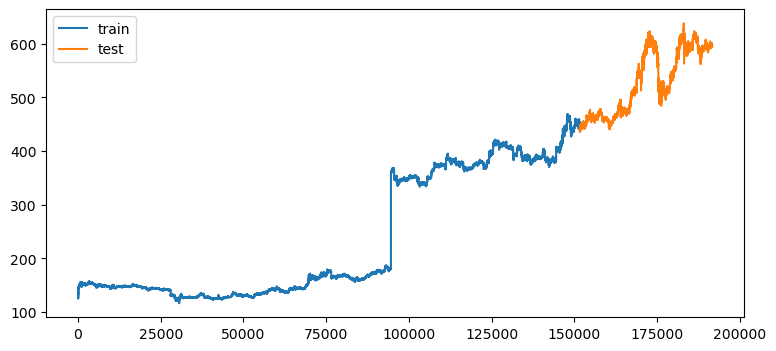

In [11]:
steps = 40000
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [12]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 151653] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-26 23:17:51 
Last fit date: 2023-02-26 23:18:39 
Skforecast version: 0.6.0 
Python version: 3.10.9 

In [13]:
steps = 40000
predictions = forecaster.predict(steps=steps)
predictions.head(5)

151654    442.3876
151655    442.2360
151656    442.2979
151657    442.5890
151658    442.6058
Name: pred, dtype: float64

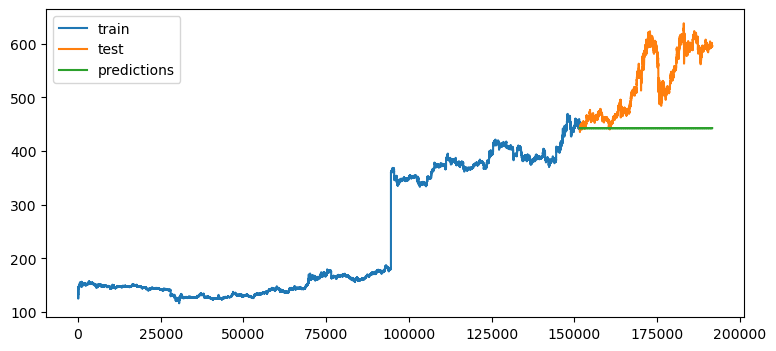

In [14]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [15]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 10997.78857531805


In [16]:
new_df = df.loc[110000:200000]

In [18]:
new_df

,timestamp,y,x_1,x_2,x_3,x_4,x_5
110000,2020-10-11 17:10:00+00:00,375.66,375.46,375.46,375.36,375.39,375.23
110001,2020-10-11 17:11:00+00:00,375.58,375.66,375.46,375.46,375.36,375.39
110002,2020-10-11 17:12:00+00:00,375.41,375.58,375.66,375.46,375.46,375.36
110003,2020-10-11 17:13:00+00:00,375.27,375.41,375.58,375.66,375.46,375.46
110004,2020-10-11 17:14:00+00:00,375.17,375.27,375.41,375.58,375.66,375.46
...,...,...,...,...,...,...,...
191649,2020-12-07 09:59:00+00:00,595.90,595.15,594.63,595.15,596.40,596.04
191650,2020-12-07 10:00:00+00:00,595.13,595.90,595.15,594.63,595.15,596.40
191651,2020-12-07 10:01:00+00:00,594.91,595.13,595.90,595.15,594.63,595.15
191652,2020-12-07 10:02:00+00:00,594.82,594.91,595.13,595.90,595.15,594.63


In [19]:
new_df.set_index('timestamp')

,y,x_1,x_2,x_3,x_4,x_5
timestamp,,,,,,
2020-10-11 17:10:00+00:00,375.66,375.46,375.46,375.36,375.39,375.23
2020-10-11 17:11:00+00:00,375.58,375.66,375.46,375.46,375.36,375.39
2020-10-11 17:12:00+00:00,375.41,375.58,375.66,375.46,375.46,375.36
2020-10-11 17:13:00+00:00,375.27,375.41,375.58,375.66,375.46,375.46
2020-10-11 17:14:00+00:00,375.17,375.27,375.41,375.58,375.66,375.46
...,...,...,...,...,...,...
2020-12-07 09:59:00+00:00,595.90,595.15,594.63,595.15,596.40,596.04
2020-12-07 10:00:00+00:00,595.13,595.90,595.15,594.63,595.15,596.40
2020-12-07 10:01:00+00:00,594.91,595.13,595.90,595.15,594.63,595.15


Train dates : 110000 --- 171653  (n=61654)
Test dates  : 171654 --- 191653  (n=20000)


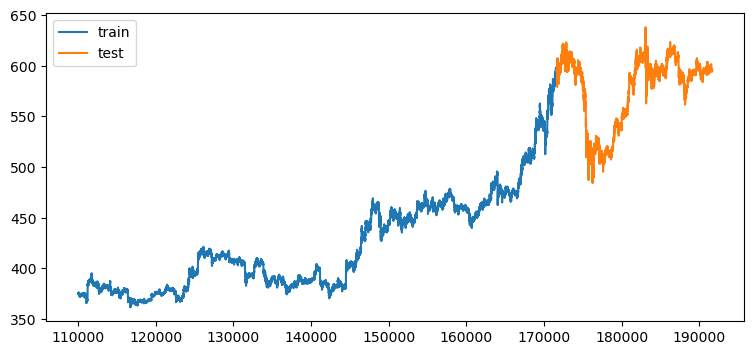

In [20]:
steps = 20000
data_train = new_df[:-steps]
data_test  = new_df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [21]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [110000, 171653] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-26 23:23:37 
Last fit date: 2023-02-26 23:23:56 
Skforecast version: 0.6.0 
Python version: 3.10.9 

In [23]:
steps = 20000
predictions = forecaster.predict(steps=steps)
predictions.head(5)

171654    594.7481
171655    594.9837
171656    594.9168
171657    594.7820
171658    594.9770
Name: pred, dtype: float64

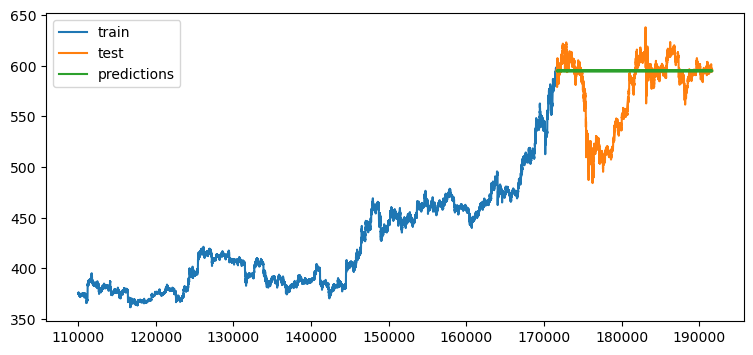

In [24]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [26]:
# Hyperparameter Grid search
# ==============================================================================
steps = 20000
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid:   0%|                                               | 0/2 [00:00<?, ?it/s]